### Explanation of the Environment Class and Shortest Path Finding

### Overview

The `Environment` class is designed to find the shortest path from a start point to a goal point in a 2D plane containing obstacles represented by polygons. The class performs the following steps:
1. Identifies accessible points that are not obstructed by any polygons.
2. Builds a graph where nodes are accessible points and edges represent unobstructed paths.
3. Applies Dijkstra’s algorithm to find the shortest path from the start to the goal point.

### Detailed Explanation

### 1. Identifying Accessible Points

**Method:** `get_points()`  
- **Purpose:** Collects all points from the polygons that are accessible, meaning they are not inside any other polygon (obstacle).  
- **Process:**
  - Iterates through each polygon and its vertices.
  - For each point:
    - Checks if it is inside any other polygon using `contains_point()`.
    - If not inside any other polygon, the point is considered accessible.
  - Adds the start and goal points to the list of accessible points.  
- **Result:** A list `self.accessible_points` containing unique, accessible points.

**Code Snippet:**
```python
def get_points(self):
    points = []
    for polygon in self.polygons:
        for point in polygon.points:
            accesible = True
            for polygon2 in self.polygons:
                if polygon != polygon2 and polygon2.contains_point(point):
                    accesible = False
            if accesible:
                points.append(point)
    return points
```
### 2. Building the Graph

- **Purpose:** Creates an adjacency matrix representing the graph where nodes are accessible points, and edges represent direct paths that do not intersect any obstacles.

- **Process:**
  1. Initializes an `n x n` adjacency matrix filled with infinity (`math.inf`), where `n` is the number of accessible points.
  2. For each pair of accessible points `(i, j)`:
     - If `i == j`, set `adj_matrix[i][j] = 0`.
     - Otherwise:
       - Checks if the straight line between points `i` and `j` intersects any polygon using `intersects_polygon()`.
       - If no intersection:
         - Calculates the Euclidean distance between the points.
         - Updates `adj_matrix[i][j]` with this distance.
       - If there is an intersection:
         - Leaves `adj_matrix[i][j]` as infinity (no direct path).

- **Result:** An adjacency matrix representing the graph of accessible points.

Code Snippet:
```python
def adjacency_matrix(self):
    n = len(self.accessible_points)
    adj_matrix = [[math.inf for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                adj_matrix[i][j] = 0
            else:
                path_intersectes_poly = False
                for polygon in self.polygons:
                    if polygon.intersects_polygon(self.accessible_points[i], self.accessible_points[j]):
                        path_intersectes_poly = True
                if not path_intersectes_poly:
                    adj_matrix[i][j] = self.dist(self.accessible_points[i], self.accessible_points[j])
    return np.array(adj_matrix)
```

### 3. Applying Dijkstra’s Algorithm

- **Purpose:** Finds the shortest path from the start point to the goal point using Dijkstra’s algorithm.

- **Process:**
  1. **Initialization:**
     - Retrieves the adjacency matrix from `adjacency_matrix()`.
     - Sets up:
       - `distances`: A list to hold the shortest known distance to each node, initialized to infinity, except the start node (distance 0).
       - `predecessors`: A list to reconstruct the shortest path.
       - A min-heap `heap` to select the next node with the smallest distance.

  2. **Algorithm Execution:**
     - While the heap is not empty:
       - Pops the node with the smallest known distance (`current_node`).
       - If `current_node` is the goal, the shortest path is found.
       - For each neighbor of `current_node`:
         - If there is an edge (distance not infinity):
           - Calculates `distance = current_distance + edge_weight`.
           - If this distance is less than the known distance to the neighbor:
             - Updates `distances[neighbor]` and `predecessors[neighbor]`.
             - Adds the neighbor to the heap.

  3. **Path Reconstruction:**
     - Backtracks from the goal node using the `predecessors` list to build `self.path_indices`.
     - Translates `self.path_indices` into actual points `self.path_points`.

- **Result:** The shortest path from the start to the goal point, if it exists.

Code Snippet:
```python
def dijkstra_shortest_path(self):
    A = self.adjacency_matrix()
    n = len(A)
    start = 0
    goal = n - 1

    distances = [float('inf')] * n
    distances[start] = 0
    predecessors = [None] * n

    heap = [(0, start)]

    while heap:
        current_distance, current_node = heapq.heappop(heap)

        if current_node == goal:
            break

        for neighbor in range(n):
            edge_weight = A[current_node][neighbor]
            if edge_weight != float('inf') and edge_weight > 0:
                distance = current_distance + edge_weight
                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    predecessors[neighbor] = current_node
                    heapq.heappush(heap, (distance, neighbor))

    path = []
    current = goal
    if distances[goal] == float('inf'):
        print("No path exists from start to goal.")
        return None, distances

    while current is not None:
        path.insert(0, current)
        current = predecessors[current]

    return path, distances
```
### 4. Visualization

## Supporting Classes and Methods

### Polygon Class

The `Polygon` class represents the obstacles and provides methods to check for intersections and point containment.

#### Method: `intersects_polygon(segment_start, segment_end)`

- **Purpose:** Determines if a line segment intersects with the polygon.  
- **Process:** For each edge of the polygon, checks for intersection with the given segment.

#### Method: `contains_point(point)`

- **Purpose:** Checks if a point is inside the polygon.  
- **Process:** Implements the Ray Casting Algorithm:
  - Casts a horizontal ray to the right from the point.
  - Counts the number of times this ray intersects with the polygon’s edges.
  - An odd count indicates the point is inside; even indicates outside.


### Summary

The `Environment` class effectively finds the shortest path by:
1. **Collecting Accessible Points:** Ensuring only points not obstructed by obstacles are considered.
2. **Building the Graph:** Representing possible direct paths between points without intersecting obstacles.
3. **Applying Dijkstra’s Algorithm:** Finding the shortest path in the graph from the start to the goal.

This process results in a path that navigates around obstacles in the most efficient way possible.

Example Usage


```python
# Define obstacles as polygons
polygon1 = Polygon(points=[(1, 1), (2, 1), (2, 2), (1, 2)])
polygon2 = Polygon(points=[(3, 3), (4, 3), (4, 4), (3, 4)])

# Define start and goal points
start_point = (0, 0)
goal_point = (5, 5)

# Create the environment
env = Environment(polygons=[polygon1, polygon2], start=start_point, goal=goal_point)

# Plot the environment and the shortest path
env.plot_environment()
```



In [87]:
import math
import heapq
import matplotlib.pyplot as plt

class Polygon:
    def __init__(self, points=None):
        self.points = points if points else []
        self.hull = self.get_convex_hull()

    def add_point(self, point):
        self.points.append(point)
        self.hull = self.get_convex_hull()

    def remove_point(self, point):
        if point in self.points:
            self.points.remove(point)
            self.hull = self.get_convex_hull()

    def get_convex_hull(self):
        # Compute the convex hull using Graham's scan
        def orientation(p, q, r):
            return (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

        points = sorted(set(self.points))  # Remove duplicates and sort
        if len(points) <= 1:
            return points

        lower = []
        for p in points:
            while len(lower) >= 2 and orientation(lower[-2], lower[-1], p) <= 0:
                lower.pop()
            lower.append(p)

        upper = []
        for p in reversed(points):
            while len(upper) >= 2 and orientation(upper[-2], upper[-1], p) <= 0:
                upper.pop()
            upper.append(p)

        return lower[:-1] + upper[:-1]

    def plot_points_and_hull(self):
        plt.figure(figsize=(8, 6))

        # Plot all points
        x, y = zip(*self.points) if self.points else ([], [])
        plt.scatter(x, y, label="Points", color="blue", zorder=2)

        # Plot the convex hull
        if self.hull:
            hull_x, hull_y = zip(*(self.hull + [self.hull[0]]))  # Close the hull loop
            plt.plot(hull_x, hull_y, label="Convex Hull", color="red", zorder=1)

        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title("Convex Hull and Points")
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_intersection_points(self, segment_start, segment_end):
        """Returns a list of intersection points between the line segment and the polygon edges."""
        if not self.hull or len(self.hull) < 3:
            return []  # Not a valid polygon

        def line_intersection(p1, p2, p3, p4):
            """Calculates the intersection point between two line segments if it exists."""
            x1, y1 = p1
            x2, y2 = p2
            x3, y3 = p3
            x4, y4 = p4

            denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denominator == 0:
                return None  # Lines are parallel or coincident

            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

            # Check if the intersection point lies on both segments
            if (min(x1, x2) - 1e-8 <= px <= max(x1, x2) + 1e-8 and
                min(y1, y2) - 1e-8 <= py <= max(y1, y2) + 1e-8 and
                min(x3, x4) - 1e-8 <= px <= max(x3, x4) + 1e-8 and
                min(y3, y4) - 1e-8 <= py <= max(y3, y4) + 1e-8):
                return (px, py)
            else:
                return None

        intersection_points = []
        n = len(self.hull)
        for i in range(n):
            p1 = self.hull[i]
            p2 = self.hull[(i + 1) % n]

            intersect_point = line_intersection(p1, p2, segment_start, segment_end)
            if intersect_point is not None:
                intersection_points.append(intersect_point)

        return intersection_points

    def intersects_polygon(self, segment_start, segment_end):
        intersection_points = list(set(self.get_intersection_points(segment_start, segment_end)))
        if len(intersection_points) <= 1:
            return False
        if len(intersection_points) == 2:
            if self.no_edge_contains_both_points(intersection_points[0], intersection_points[1]):
                return True
            else:
                return False
        else:
            return True

    def no_edge_contains_both_points(self, point1, point2):
        """
        Returns True if there is no edge in the polygon that contains both point1 and point2.
        Returns False if both points lie on the same edge of the polygon.
        """
        if not self.hull or len(self.hull) < 2:
            return True  # Polygon has no edges to check

        for i in range(len(self.hull)):
            edge_start = self.hull[i]
            edge_end = self.hull[(i + 1) % len(self.hull)]

            # Check if both points lie on the current edge
            if self._point_on_edge(point1, edge_start, edge_end) and self._point_on_edge(point2, edge_start, edge_end):
                return False  # Both points lie on the same edge

        return True  # No edge contains both points

    def _point_on_edge(self, point, edge_start, edge_end):
        """
        Helper method to check if a point lies on a given edge (line segment).
        """
        x, y = point
        x1, y1 = edge_start
        x2, y2 = edge_end

        # Calculate the cross product to check colinearity
        cross = (y - y1) * (x2 - x1) - (x - x1) * (y2 - y1)
        if abs(cross) > 1e-8:
            return False  # Not colinear

        # Check if the point lies between the edge's endpoints
        dot_product = (x - x1) * (x2 - x1) + (y - y1) * (y2 - y1)
        if dot_product < 0:
            return False  # Point is before edge_start

        squared_length = (x2 - x1) ** 2 + (y2 - y1) ** 2
        if dot_product > squared_length:
            return False  # Point is after edge_end

        return True  # Point lies on the edge

    def contains_point(self, point):
        """Check if the point is inside the polygon using the ray casting method."""
        x, y = point
        num_vertices = len(self.hull)
        inside = False

        for i in range(num_vertices):
            xi, yi = self.hull[i]
            xj, yj = self.hull[(i + 1) % num_vertices]

            if ((yi > y) != (yj > y)) and \
               (x < (xj - xi) * (y - yi) / (yj - yi + 1e-4) + xi):
                inside = not inside

        return inside



In [88]:
import numpy as np
class Environment:
    def __init__(self, polygons=None, start=None, goal=None):
        self.polygons = polygons if polygons else []
        self.start = start
        self.goal = goal
        self.congfiguration_valid = True

        # Remove duplicates while preserving order
        points = self.get_points()
        seen = set()
        unique_points = []
        for point in points:
            if point not in seen:
                seen.add(point)
                unique_points.append(point)
        

        self.accessible_points = [self.start] + unique_points + [self.goal]
        self.path_indices, self.distances = self.dijkstra_shortest_path()
        
        for polygon in self.polygons:
            if polygon.contains_point(self.start) or polygon.contains_point(self.goal):
                self.congfiguration_valid = False
                print("Start or goal point is inside a polygon")
                self.accessible_points = []
                self.path_indices = []

        if self.path_indices:
            self.path_points = [self.accessible_points[i] for i in self.path_indices]
        else:
            self.path_points = []

    def get_points(self):
        points = []
        for polygon in self.polygons:
            for point in polygon.points:
                accesible = True
                for polygon2 in self.polygons:
                    if polygon != polygon2 and polygon2.contains_point(point):
                        accesible = False
                if accesible:
                    points.append(point)
        return points
    
    def dist(self, point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    
    def adjacency_matrix(self):
        n = len(self.accessible_points)
        # adjacency matrix is a np matrix of size n x n initialized with infinity
        adj_matrix = [[math.inf for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                if i == j:
                    adj_matrix[i][j] = 0
                else:
                    path_intersectes_poly = False
                    for polygon in self.polygons:
                        if polygon.intersects_polygon(self.accessible_points[i], self.accessible_points[j]) :
                            path_intersectes_poly = True
                        
                    if not path_intersectes_poly:
                        adj_matrix[i][j] = self.dist(self.accessible_points[i], self.accessible_points[j])
        return np.array(adj_matrix)
    
    def dijkstra_shortest_path(self):
        """
        Finds the shortest path from the start node (index 0) to the goal node (index -1)
        using Dijkstra's algorithm.

        Parameters:
        - A: 2D list or numpy array representing the adjacency matrix of the graph.

        Returns:
        - path: List of node indices representing the shortest path from start to goal.
                Returns None if no path exists.
        - distances: List of distances from the start node to each node.
        """
        A = self.adjacency_matrix()
        n = len(A)
        start = 0
        goal = n - 1

        # Initialize distances and predecessor lists
        distances = [float('inf')] * n
        distances[start] = 0
        predecessors = [None] * n

        # Priority queue to select the node with the smallest distance
        heap = [(0, start)]

        while heap:
            current_distance, current_node = heapq.heappop(heap)

            # If we reached the goal node, break
            if current_node == goal:
                break

            # Check all adjacent nodes
            for neighbor in range(n):
                edge_weight = A[current_node][neighbor]
                if edge_weight != float('inf') and edge_weight > 0:
                    distance = current_distance + edge_weight
                    if distance < distances[neighbor]:
                        distances[neighbor] = distance
                        predecessors[neighbor] = current_node
                        heapq.heappush(heap, (distance, neighbor))

        # Reconstruct the shortest path
        path = []
        current = goal
        if distances[goal] == float('inf'):
            print("No path exists from start to goal.")
            return None, distances

        while current is not None:
            path.insert(0, current)
            current = predecessors[current]

        return path, distances
    
    def plot_environment(self):
        # plot the start point end point and the polygons
        # plot the shortest path
        # shade the area that is not accessible

        plt.figure(figsize=(8, 6))

        # Plot the polygons
        for polygon in self.polygons:
            x, y = zip(*polygon.hull + [polygon.hull[0]])
            plt.plot(x, y, color="black", zorder=1)
        
        # Plot the start and goal points
        plt.scatter(*self.start, color="green", label="Start", zorder=3)
        plt.scatter(*self.goal, color="red", label="Goal", zorder=3)

        # Plot the shortest path
        if self.path_points:
            x, y = zip(*self.path_points)
            plt.plot(x, y, color="blue", label="Shortest Path", zorder=2)
        
        
        # shade polygons
        for polygon in self.polygons:
            x, y = zip(*polygon.hull + [polygon.hull[0]])
            plt.fill(x, y, color="gray", alpha=0.5, zorder=0)
        # plot the graph
        for i in range(len(self.accessible_points)):
            for j in range(len(self.accessible_points)):
                if self.adjacency_matrix()[i][j] != math.inf:
                    plt.plot([self.accessible_points[i][0], self.accessible_points[j][0]], [self.accessible_points[i][1], self.accessible_points[j][1]], color="black", zorder=0)

        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title("Environment")
        plt.legend()
        plt.grid(True)
        plt.show()
        
            
        

Start or goal point is inside a polygon


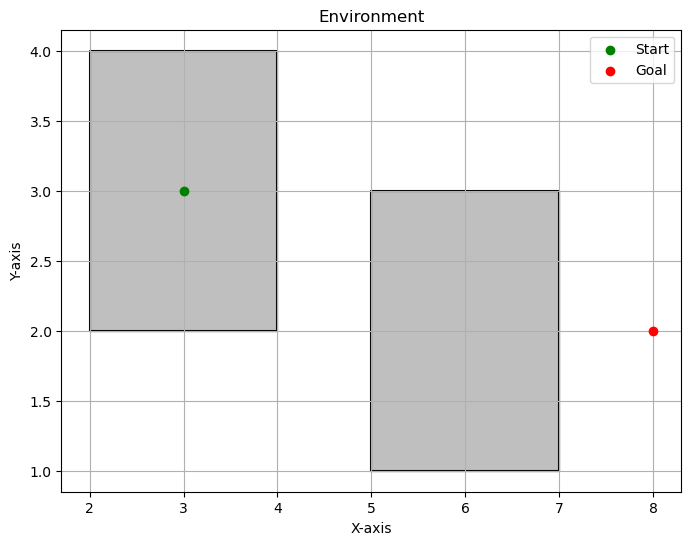

In [89]:

polygon1 = Polygon([(2, 2), (4, 2), (4, 4), (2, 4)])
polygon2 = Polygon([(5, 1), (7, 1), (7, 3), (5, 3)])

polygons = [polygon1, polygon2]


# Start and goal positions
start = (3, 3)
goal = (8, 2)

env = Environment(polygons, start, goal)
env.plot_environment()


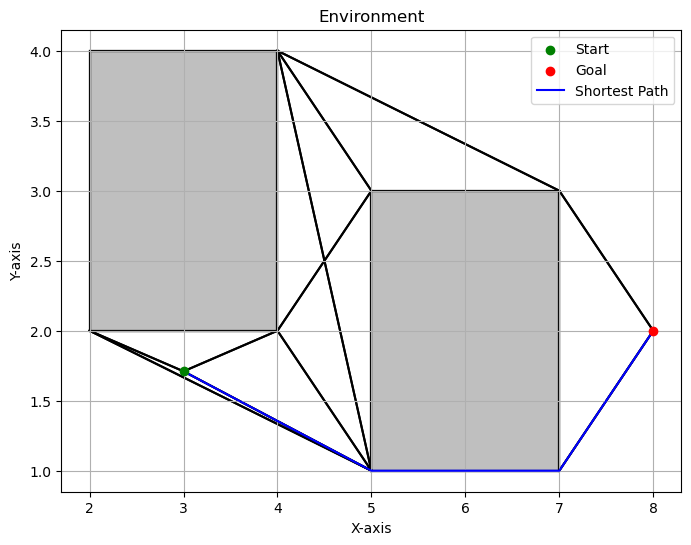

In [90]:

# Define polygons using the provided Polygon class
polygon1 = Polygon([(2, 2), (4, 2), (4, 4), (2, 4)])
polygon2 = Polygon([(5, 1), (7, 1), (7, 3), (5, 3)])
polygons = [polygon1, polygon2]

# Start and goal positions
start = (3, 1.71)
goal = (8, 2)

env = Environment(polygons, start, goal)
env.plot_environment()


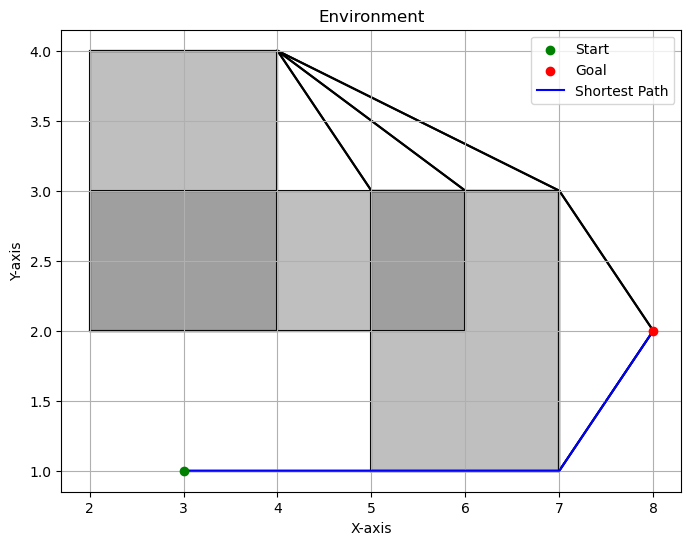

In [91]:
# Define polygons using the provided Polygon class
polygon1 = Polygon([(2, 2), (4, 2), (4, 4), (2, 4)])
polygon2 = Polygon([(5, 1), (7, 1), (7, 3), (5, 3)])
polygon3 = Polygon([(2, 2), (6, 2), (6, 3), (2, 3)])

polygons = [polygon1, polygon2, polygon3]

# Start and goal positions


start = (3, 1)
goal = (8, 2)

env = Environment(polygons, start, goal)
env.plot_environment()


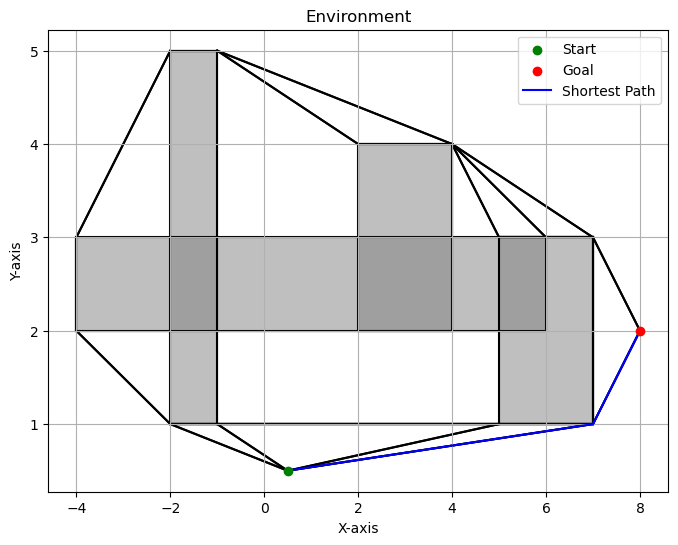

In [92]:
polygon1 = Polygon([(2, 2), (4, 2), (4, 4), (2, 4)])
polygon2 = Polygon([(5, 1), (7, 1), (7, 3), (5, 3)])
polygon3 = Polygon([(-4, 2), (6, 2), (6, 3), (-4, 3)])
polygon4 = Polygon([(-2, 1), (-2, 5), (-1, 5), (-1, 1)])


polygons = [polygon1, polygon2, polygon3, polygon4]

# Start and goal positions

goal = (8, 2)
start = (0.5, 0.5)

env = Environment(polygons, start, goal)
env.plot_environment()

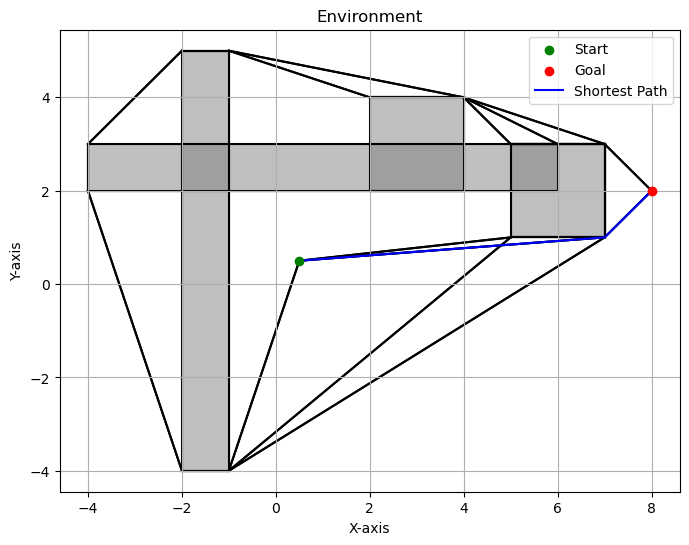

In [93]:
# Define polygons using the provided Polygon class
# 4 polygons that enclose the startpoint 
polygon1 = Polygon([(2, 2), (4, 2), (4, 4), (2, 4)])
polygon2 = Polygon([(5, 1), (7, 1), (7, 3), (5, 3)])
polygon3 = Polygon([(-4, 2), (6, 2), (6, 3), (-4, 3)])
polygon4 = Polygon([(-2, -4), (-2, 5), (-1, 5), (-1, -4)])


polygons = [polygon1, polygon2, polygon3, polygon4]

# Start and goal positions

goal = (8, 2)
start = (0.5, 0.5)

env = Environment(polygons, start, goal)
env.plot_environment()

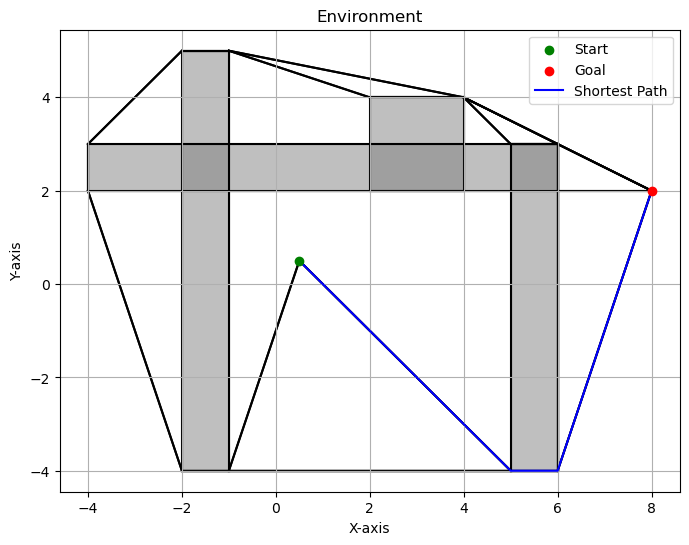

In [94]:
# Define polygons using the provided Polygon class
# 4 polygons that enclose the startpoint 
polygon1 = Polygon([(2, 2), (4, 2), (4, 4), (2, 4)])
polygon2 = Polygon([(5, -4), (6, -4), (6, 3), (5, 3)])
polygon3 = Polygon([(-4, 2), (6, 2), (6, 3), (-4, 3)])
polygon4 = Polygon([(-2, -4), (-2, 5), (-1, 5), (-1, -4)])


polygons = [polygon1, polygon2, polygon3, polygon4]

# Start and goal positions

goal = (8, 2)
start = (0.5, 0.5)

env = Environment(polygons, start, goal)
env.plot_environment()

No path exists from start to goal.


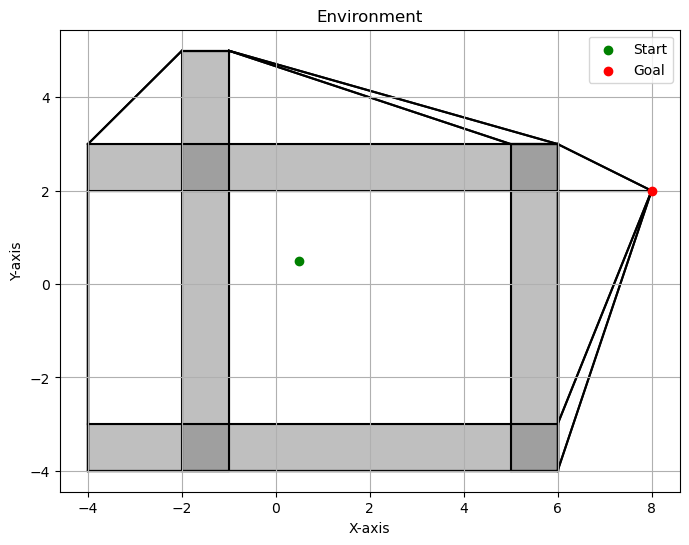

In [95]:
# Define polygons using the provided Polygon class
# 4 polygons that enclose the startpoint 
polygon1 = Polygon([(-4, -4), (6, -4), (6, -3), (-4, -3)])
polygon2 = Polygon([(5, -4), (6, -4), (6, 3), (5, 3)])
polygon3 = Polygon([(-4, 2), (6, 2), (6, 3), (-4, 3)])
polygon4 = Polygon([(-2, -4), (-2, 5), (-1, 5), (-1, -4)])


polygons = [polygon1, polygon2, polygon3, polygon4]

# Start and goal positions

goal = (8, 2)
start = (0.5, 0.5)

env = Environment(polygons, start, goal)
env.plot_environment()